In [1]:
# author: René Kopeinig
# script: Linear Regression
# description: Linear Regression on Proba-V NDVI, Landsat 8 NDVI and CHIRPS precipitation Time-Series
#              Note: Please make sure you have all dependencies in Python installed and you are signed up for Google Earth Engine.

In [2]:
# Add IPython-specific directive to display plots directly below the notebook cell
%matplotlib inline

In [3]:
# Import Dependencies
import ee, datetime
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.formula.api as smf
from IPython.display import Image
from matplotlib import dates
from pylab import *
from numpy import fft
from statsmodels.tsa.stattools import adfuller
from pandas.tseries.offsets import MonthEnd
from sklearn.linear_model import LinearRegression
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [4]:
# Initialize
ee.Initialize()

# Set start and end date
startTime = datetime.datetime(2013, 2, 3)
endTime = datetime.datetime(2018, 4, 15)

# Create image collection
l8 = ee.ImageCollection('LANDSAT/LC8_L1T_TOA').filterDate(startTime, endTime)
precipitation = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD').filterDate(startTime, endTime)
probav = ee.ImageCollection('VITO/PROBAV/C1/S1_TOC_100M').filterDate(startTime, endTime)
point = {'type':'Point', 'coordinates':[-99.545934,20.572173]};

In [5]:
#Retrieve information over image collection
info_l8 = l8.getRegion(point,500).getInfo()
info_chirps = precipitation.getRegion(point, 500).getInfo()
info_probav = probav.getRegion(point, 500).getInfo()

In [6]:
# Reshape Landsat 8
header = info_l8[0]
data = array(info_l8[1:])

iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

# List of used image bands
band_list = ['B5',u'B4']

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(np.float)

# Calculate NDVI
red = yData[:,0]
nir = yData[:,1]
ndvi = (nir - red) / (nir + red)

# Reshape NDVI array into Pandas Dataframe
df = pd.DataFrame(data=ndvi*-1, index=time, columns=['ndvi'])
l8_time_series = df.dropna()

# Resampling
monthly_landsat = l8_time_series.resample('M', how='mean')

/Users/rkopei/venv/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()


In [7]:
# Reshape Chirps precipitation data 
header = info_chirps[0]
data = array(info_chirps[1:])
iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

band_list=['precipitation']
iBands = [header.index(b) for b in band_list]
chirps = data[0:,iBands].astype(np.float)

df = pd.DataFrame(data=chirps, index=time, columns=['precipitation'])
chirps_time_series = df.dropna()

# Resampling
monthly_chirps = chirps_time_series.resample('M', how='mean')

/Users/rkopei/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  from ipykernel import kernelapp as app


In [8]:
# Reshape Proba-V image collection 
header = info_probav[0]
data = array(info_probav[1:])
iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

band_list=['NDVI']
iBands = [header.index(b) for b in band_list]
ndvi = data[0:,iBands].astype(np.float)

df = pd.DataFrame(data=ndvi, index=time, columns=['ndvi'])
probav_time_series = df.dropna()

# Resampling
monthly_probav = probav_time_series.resample('M', how='mean')

/Users/rkopei/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  from ipykernel import kernelapp as app


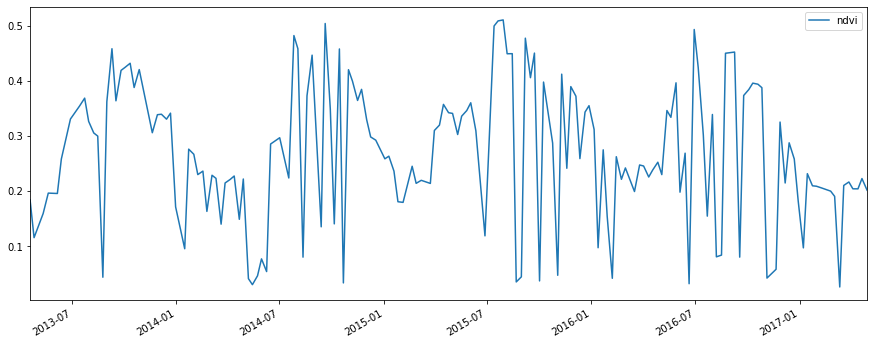

In [9]:
# Plot Proba-V NDVI Time Series
l8_time_series.plot()

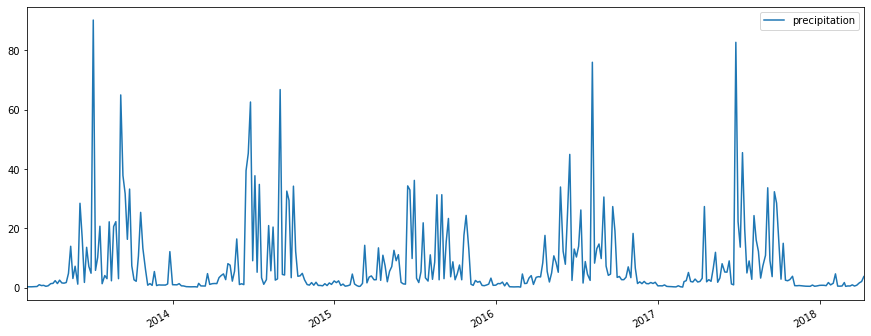

In [10]:
# Plot CHIRPS Time Series
chirps_time_series.plot()

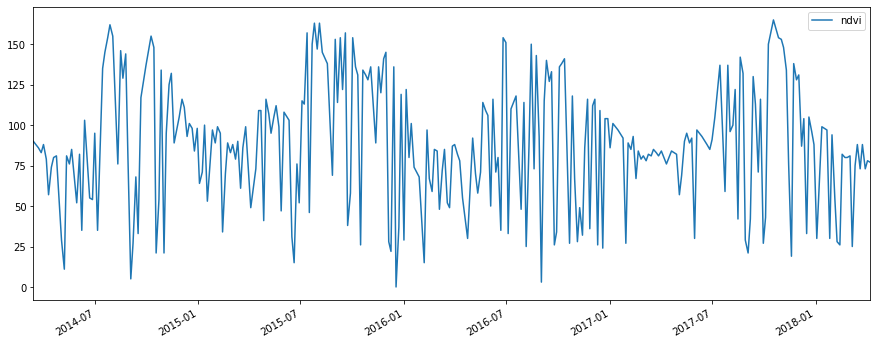

In [11]:
# Plot Proba-V NDVI Time Series
probav_time_series.plot()

In [12]:
# Change temporal resolution
monthly_chirps = monthly_chirps['2014-04':'2017-04']
monthly_landsat = monthly_landsat['2014-04':'2017-04']
monthly_probav = monthly_probav['2014-04':'2017-04']

In [13]:
monthly = pd.DataFrame({'landsat': monthly_landsat['ndvi'],
                        'chirps': monthly_chirps['precipitation'],
                        'probav':monthly_probav['ndvi']},index = monthly_chirps.index)

/Users/rkopei/venv/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


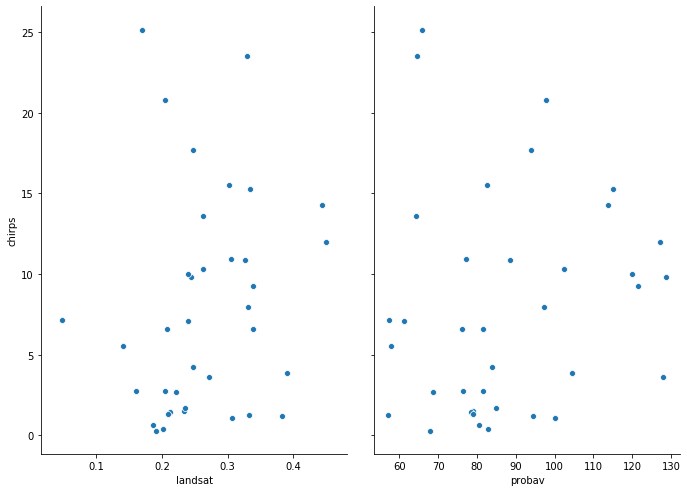

In [14]:
# Pair plot
sns.pairplot(monthly, x_vars=['landsat', 'probav'], y_vars=['chirps'], size=7, aspect=0.7)

In [15]:
# Linear Regression comparing SciKit-Learn and Statsmodels

In [16]:
# Statsmodels
lm_1 = smf.ols(formula='chirps ~ landsat', data=monthly).fit()

# Print the coefficients
print(lm_1.params)

Intercept     4.081701
landsat      14.312617
dtype: float64


In [17]:
# scikit-learn

cols = ['landsat']
X = monthly[cols]
y = monthly.chirps

# instantiate and fit
lm_2 = LinearRegression()
lm_2.fit(X, y)

# print the coefficients
print('Intercept: ', lm_2.intercept_)
print('landsat: ', lm_2.coef_[0])

Intercept:  4.081700556631769
landsat:  14.312617180230179


/Users/rkopei/venv/lib/python3.7/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


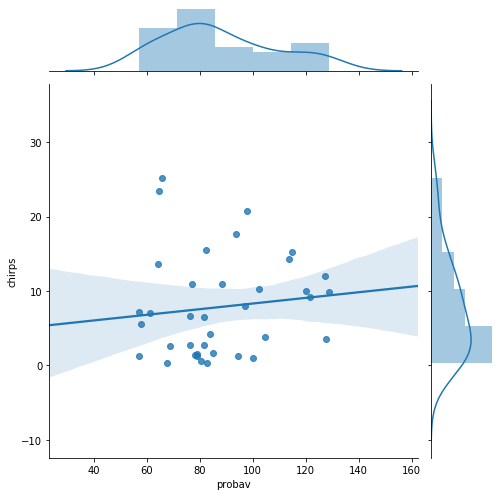

In [18]:
# Plot Least Square Line
sns.jointplot("probav", "chirps", data=monthly, size=7, kind='reg')

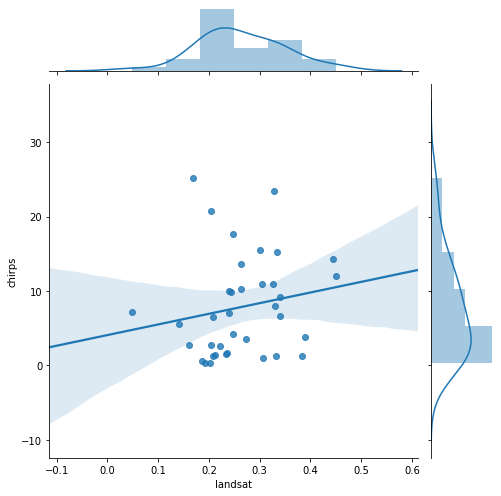

In [19]:
sns.jointplot("landsat", "chirps", data=monthly, size=7, kind='reg')

In [21]:
# You also could do this, your attribute of interest versus time
probav_time_series['time'] = np.arange(len(probav_time_series))

# Statsmodels
lm = smf.ols(formula='ndvi ~ time', data=probav_time_series).fit()

# Print the coefficients
print(lm.params)

Intercept    90.890747
time         -0.020495
dtype: float64


/Users/rkopei/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


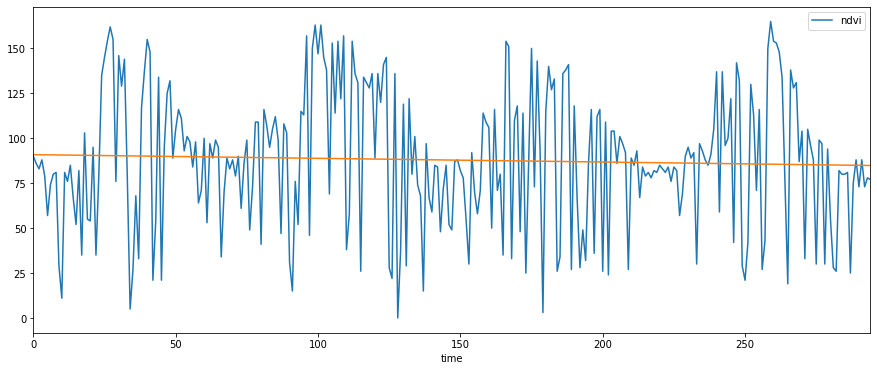

In [22]:
model_linear_pred = lm.predict()
probav_time_series.plot(kind='line', x='time', y='ndvi')
plt.plot(probav_time_series.time, model_linear_pred, '-')

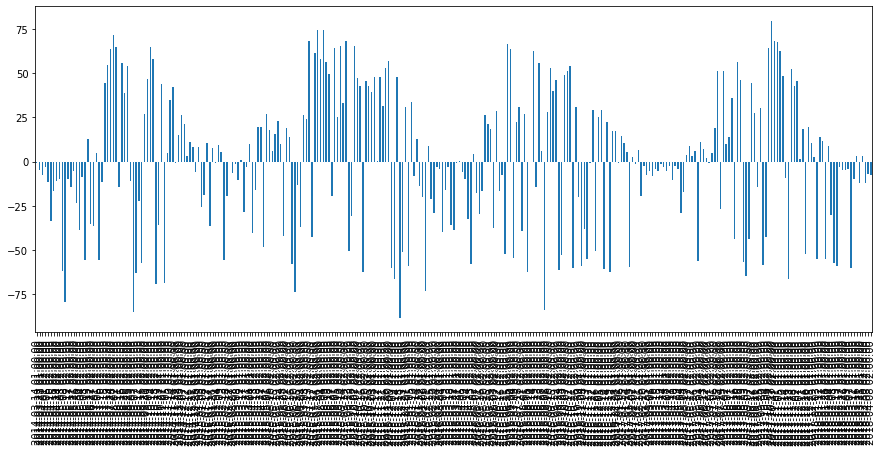

In [23]:
# Plot residuals
lm.resid.plot(kind='bar')

In [24]:
# OLS Regression Summary
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ndvi   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6070
Date:                Fri, 12 Jul 2019   Prob (F-statistic):              0.437
Time:                        21:38:15   Log-Likelihood:                -1494.3
No. Observations:                 295   AIC:                             2993.
Df Residuals:                     293   BIC:                             3000.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     90.8907      4.469     20.338      0.000      82.095      99.686
time          -0.0205      0.026     -0.779      0.437      -0.072       0.031
==============================================================================
Omnibus:                       13.626   Durbin-Watson:                   1.624
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                6.286
Skew:                          -0.083   Prob(JB):                       0.0431
Kurtosis:                       2.304   Cond. No.                         339.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""